In [1]:
import os
import sys
from pathlib import Path

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib.pyplot as plt

from utils.file_handling import *
from utils.segment3D import get_voxel_size_35mm
from utils.segment2D import get_pixel_size

sys.path.append("../../analysis/utils")
from data_class import SegmentationData

In [197]:
diff_lim = 0.3
dataset  = "holomonitor_20240516_A2-7"
use_config = False

In [198]:
df     = pd.read_csv(f"../../../data/processed/{dataset}/dataframe_unfiltered.csv")
areas  = np.load(f"../../../data/processed/{dataset}/im_cell_areas.npy")
config = json.load(open(f"../../../data/configs/{dataset}.json"))

microscope = Path(dataset).stem.split("_")[0]
microscope


'holomonitor'

In [199]:
fmin = config["segmentation"]["fmin"]
fmax = config["segmentation"]["fmax"]

if microscope == 'holomonitor':
    search_range = 10
    pix_to_um = get_pixel_size()
    h_im = import_holomonitor_stack(f"../../../data/raw/{dataset}", 
                                    f_min=config['segmentation']['fmin'],
                                    f_max=config['segmentation']['fmax'])
    n_im = np.copy(h_im)

elif microscope == 'tomocube':
    search_range = 50
    pix_to_um = get_voxel_size_35mm()
    n_im, h_im = import_tomocube_stack(f"../../../data/raw/{dataset}", 
                                       h_scaling=pix_to_um[0], 
                                       f_min=config['segmentation']['fmin'], 
                                       f_max=config['segmentation']['fmax'])

In [200]:
# set filter parameters
if use_config:

    A_min = config['filtering']['Amin']
    A_max = config['filtering']['Amax']
    V_min = config['filtering']['Vmin']
    V_max = config['filtering']['Vmax']
    h_min = config['filtering']['hmin']
    h_max = config['filtering']['hmax']

else:
    A_min = 100
    A_max = 2000
    V_min = 800
    V_max = 10000
    h_min = 1
    h_max = 18

In [201]:
# create masks
h_mask = (df.h_avrg > h_min) * (df.h_max < h_max) 
A_mask = (df.A > A_min) * (df.A < A_max)
V_mask = (df.V > V_min) * (df.V < V_max)

mask = h_mask * A_mask * V_mask
filtered_df = df[mask]

print(f"Before filtering: {len(df)} cells")
print(f"After filtering:  {len(filtered_df)} cells")

Before filtering: 67479 cells
After filtering:  67350 cells


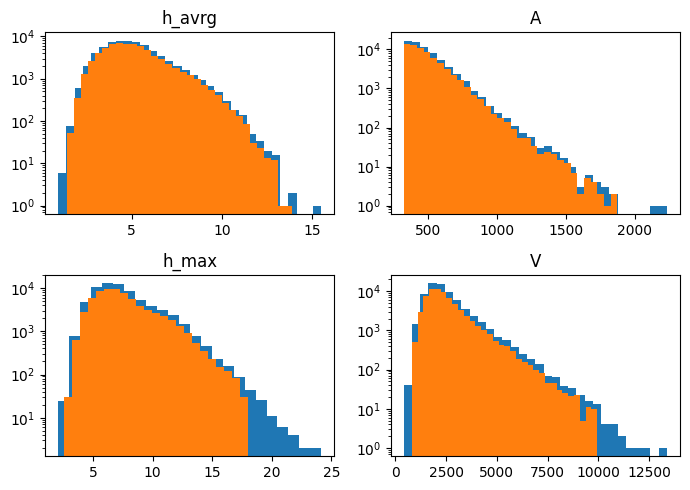

In [202]:
# filter area and volume
fig, ax = plt.subplots(2,2, figsize=(7,5))

ax[0,0].hist(df.h_avrg, bins=32)
ax[0,0].hist(filtered_df.h_avrg,   bins=32)
ax[1,0].hist(df.h_max,  bins=24)#range=(0.5, h_max+0.5), bins=h_max+1)
ax[1,0].hist(filtered_df.h_max,    bins=23)#range=(0.5, h_max+0.5), bins=h_max+1)
ax[0,1].hist(df.A,      bins=32)
ax[0,1].hist(filtered_df.A,        bins=32)
ax[1,1].hist(df.V,      bins=32)
ax[1,1].hist(filtered_df.V,        bins=32)

ax[0,0].set(title="h_avrg", yscale="log")
ax[1,0].set(title="h_max",  yscale="log")
ax[0,1].set(title="A",      yscale="log")
ax[1,1].set(title="V",      yscale="log")
fig.tight_layout()

#fig.savefig(f"{dir}{file}/figs/filter_illustration.png", dpi=100)

In [203]:
# save filter config
config['filtering']["hmin"] = h_min
config['filtering']["hmax"] = h_max
config['filtering']["Amin"] = A_min
config['filtering']["Amax"] = A_max
config['filtering']["Vmin"] = V_min
config['filtering']["Vmax"] = V_max

json.dump(config, open(f"../../../data/configs/{dataset}.json", "w"))

Before: 409
After:  408


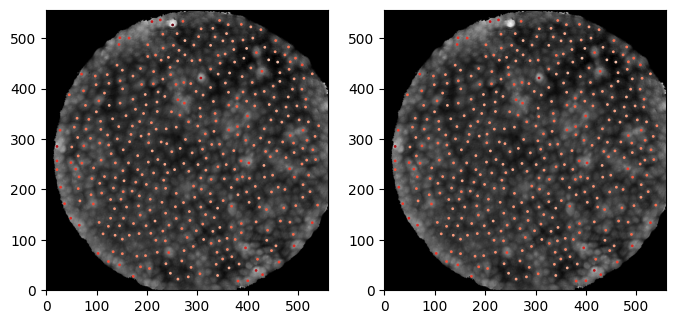

In [ ]:
# verify filtering
idx = 103

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(n_im[idx].T, origin="lower", cmap="gray", vmin=1.37, extent=[0,pix_to_um[1]*len(h_im[0]), 0, pix_to_um[1]*len(h_im[0,0])]);
ax[1].imshow(n_im[idx].T, origin="lower", cmap="gray", vmin=1.37, extent=[0,pix_to_um[1]*len(h_im[0]), 0, pix_to_um[1]*len(h_im[0,0])]);
ax[0].scatter(df[df.frame==idx].x, df[df.frame==idx].y, s=1, cmap="Reds", c=df[df.frame==idx].h_max, vmin=0, vmax=h_max)#, 'r.', ms=3);
ax[1].scatter(filtered_df[filtered_df.frame==idx].x, filtered_df[filtered_df.frame==idx].y, s=1, cmap="Reds", c=filtered_df[filtered_df.frame==idx].h_max, vmin=0, vmax=h_max)#, 'r.', ms=3);

print(f"Before: {len(df[df.frame==idx])}")
print(f"After:  {len(filtered_df[filtered_df.frame==idx])}")

In [132]:
filtered_areas = np.copy(areas[idx])

for l in range(0, areas[idx].max()):
    if l not in filtered_df[filtered_df.frame==idx].label.values:
        filtered_areas[filtered_areas == l] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow((h_im[idx]*(areas[idx]>0)).T, origin="lower", cmap="gray", vmin=1.37);
ax[1].imshow((h_im[idx]*(filtered_areas>0)).T, origin="lower", cmap="gray", vmin=1.37);

ax[0].plot(df[df.frame==idx].x, df[df.frame==idx].y, 'r.', ms=2);
ax[1].plot(filtered_df[filtered_df.frame==idx].x, filtered_df[filtered_df.frame==idx].y, 'r.', ms=2);

print(sum(df.frame==idx))

IndexError: index 160 is out of bounds for axis 0 with size 121